# MatMul Analysis of multiple Matrix Size

In [1]:
import glob
from matplotlib import pyplot as plt
import os
from pprint import pprint

In [2]:
def load(root_folder: str) -> {}:
    data = {}
    for filename in glob.glob(f"./results/{root_folder}/*.txt"):
        size, _ = os.path.splitext(filename.split("-")[-1])
        size = int(size)
        if size not in (32, 64, 128, 256, 512):
            continue
        if size not in data.keys():
            data[size] = {}
        with open(filename) as f:
            data[size]["raw"] = f.readlines()
            
    return data

In [3]:
def find_lines(file_content: [str],pattern: str) -> [str]:
    result = []
    for line in file_content:
        if pattern in line:
            result.append(line)
    return result


def find_line(file_content: [str], pattern: str) -> str:
    for line in file_content:
        if pattern in line:
            return line
    return ""

In [4]:
data_480 = load("sim_480")
data_2060 = load("sim_2060")

In [5]:
def analyze(data: {}):
    for size in sorted(data.keys()):
        # Simulation Time
        data[size]["time"] = int(find_line(data[size]["raw"], "gpgpu_simulation_time").split("(")[1][:-1].split(" ")[0])

        # IPC
        data[size]["IPC"] = float(find_line(data[size]["raw"], "gpu_ipc").strip().split("=")[1].strip())

        # Execution time (sim_cycles/core_frequency)
        clock_cycles = int(find_line(data[size]["raw"], "gpu_sim_cycle").strip().split("=")[1])
        core_freq = float(find_line(data[size]["raw"], "gpgpu_clock_domains").split()[1].split(":")[0]) * 1e6  # clock is in MHz
        data[size]["exec"] = clock_cycles/core_freq
        
        # FLOP/s
        data[size]["flops"] = (size ** 2 * (2 * size)) / data[size]["exec"]
        
        # DRAM Bandwidth (bit/s) = access_width * clock * #memory
        DRAM_Clock = float(find_line(data[size]["raw"], "gpgpu_clock_domains").split()[1].split(":")[-1]) * 1e6  # clock is in MHz
        gpgpu_dram_buswidth = int(find_line(data[size]["raw"], "gpgpu_dram_buswidth").split()[1])  # gpgpu_dram_buswidth is in bytes
        gpgpu_n_mem = int(find_line(data[size]["raw"], "gpgpu_n_mem").split()[1])
        gpgpu_n_mem_per_ctrlr = int(find_line(data[size]["raw"], "gpgpu_n_mem_per_ctrlr").split()[1])

        peak_bw = (gpgpu_n_mem * gpgpu_n_mem_per_ctrlr * gpgpu_dram_buswidth * DRAM_Clock * 2) / 1e9  # GBytes/s
        
        average_utilization = [float(ut.strip().split("=")[-1]) for ut in find_lines(data[size]["raw"], "bw_util")]
        average_utilization = sum(average_utilization) / len(average_utilization)

        data[size]["DRAM_bw"] = peak_bw * average_utilization

        data[size]["occupancy"] = float(find_line(data[size]["raw"], "gpu_occupancy =").strip().split("=")[1][:-1])

In [6]:
analyze(data_480)
analyze(data_2060)

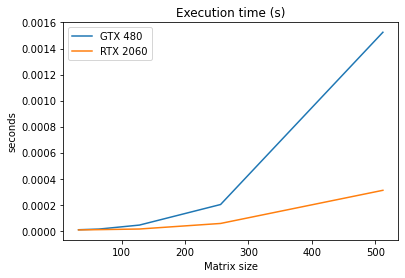

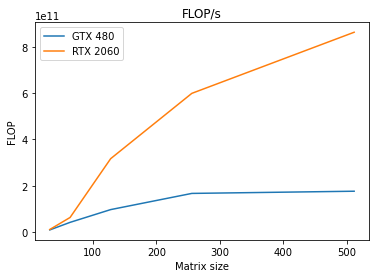

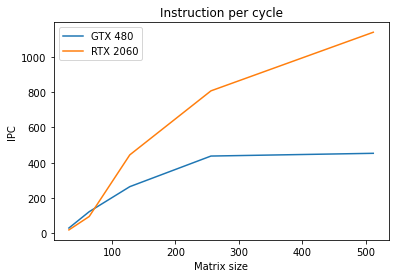

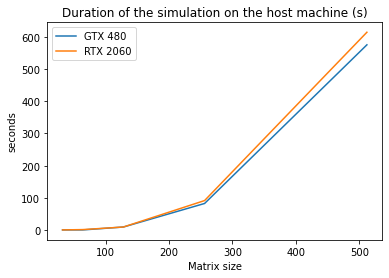

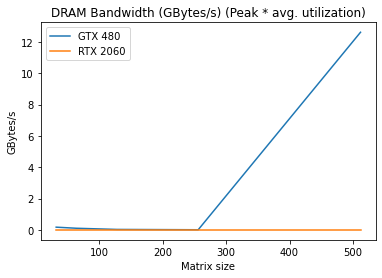

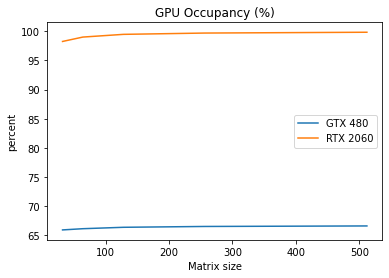

In [8]:
DPI=128

# A) Execution Time
plt.plot(sorted(data_480.keys()), [data_480[size]["exec"] for size in sorted(data_480.keys())], label="GTX 480")
plt.plot(sorted(data_2060.keys()), [data_2060[size]["exec"] for size in sorted(data_2060.keys())], label="RTX 2060")
plt.title('Execution time (s)')
plt.xlabel('Matrix size')
plt.ylabel('seconds')
plt.legend()
plt.savefig("plots/a-exec_time-480-2060.png", transparent=False, dpi=DPI)
plt.show()

# B) FLOP/s
plt.plot(sorted(data_480.keys()), [data_480[size]["flops"] for size in sorted(data_480.keys())], label="GTX 480")
plt.plot(sorted(data_2060.keys()), [data_2060[size]["flops"] for size in sorted(data_2060.keys())], label="RTX 2060")
plt.title('FLOP/s')
plt.xlabel('Matrix size')
plt.ylabel('FLOP')
plt.legend()
plt.savefig("plots/b-flop_per_s-480-2060.png", transparent=False, dpi=DPI)
plt.show()

# C) IPC
plt.plot(sorted(data_480.keys()), [data_480[size]["IPC"] for size in sorted(data_480.keys())], label="GTX 480")
plt.plot(sorted(data_2060.keys()), [data_2060[size]["IPC"] for size in sorted(data_2060.keys())], label="RTX 2060")
plt.title('Instruction per cycle')
plt.xlabel('Matrix size')
plt.ylabel('IPC')
plt.legend()
plt.savefig("plots/c-ipc-480-2060.png", transparent=False, dpi=DPI)
plt.show()

# D) Simulation Time
plt.plot(sorted(data_480.keys()), [data_480[size]["time"] for size in sorted(data_480.keys())], label="GTX 480")
plt.plot(sorted(data_2060.keys()), [data_2060[size]["time"] for size in sorted(data_2060.keys())], label="RTX 2060")
plt.title('Duration of the simulation on the host machine (s)')
plt.xlabel('Matrix size')
plt.ylabel('seconds')
plt.legend()
plt.savefig("plots/d-sim_time-480-2060.png", transparent=False, dpi=DPI)
plt.show()

# E) External Bandwidth
plt.plot(sorted(data_480.keys()), [data_480[size]["DRAM_bw"] for size in sorted(data_480.keys())], label="GTX 480")
plt.plot(sorted(data_2060.keys()), [data_2060[size]["DRAM_bw"] for size in sorted(data_2060.keys())], label="RTX 2060")
plt.title('DRAM Bandwidth (GBytes/s) (Peak * avg. utilization)')
plt.xlabel('Matrix size')
plt.ylabel('GBytes/s')
plt.legend()
plt.savefig("plots/e-ext_bw-480-2060.png", transparent=False, dpi=DPI)
plt.show()

# F) GPU Occupancy
plt.plot(sorted(data_480.keys()), [data_480[size]["occupancy"] for size in sorted(data_480.keys())], label="GTX 480")
plt.plot(sorted(data_2060.keys()), [data_2060[size]["occupancy"] for size in sorted(data_2060.keys())], label="RTX 2060")
plt.title('GPU Occupancy (%)')
plt.xlabel('Matrix size')
plt.ylabel('percent')
plt.legend()
plt.savefig("plots/f-occupancy-480-2060.png", transparent=False, dpi=DPI)
plt.show()